In [12]:
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A
import yaml
from copy import copy
from tqdm import tqdm

In [13]:
with open('./edu_train.yaml') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)
CLASSES = config['names']
print(CLASSES)

['__background__', 'text', 'junction', 'crossover', 'terminal', 'gnd', 'vss', 'voltage.dc', 'voltage.ac', 'voltage.battery', 'resistor', 'resistor.adjustable', 'resistor.photo', 'capacitor.unpolarized', 'capacitor.polarized', 'capacitor.adjustable', 'inductor', 'inductor.ferrite', 'inductor.coupled', 'transformer', 'diode', 'diode.light_emitting', 'diode.thyrector', 'diode.zener', 'diac', 'triac', 'thyristor', 'varistor', 'transistor.bjt', 'transistor.fet', 'transistor.photo', 'operational_amplifier', 'operational_amplifier.schmitt_trigger', 'optocoupler', 'integrated_circuit', 'integrated_circuit.ne555', 'integrated_circuit.voltage_regulator', 'xor', 'and', 'or', 'not', 'nand', 'nor', 'probe.current', 'probe.voltage', 'switch', 'relay', 'socket', 'fuse', 'speaker', 'motor', 'lamp', 'microphone', 'antenna', 'crystal', 'mechanical', 'magnetic', 'optical', 'block', 'unknown']


In [14]:
def loader(img_path):
    image = np.array(Image.open(img_path))

    labels_path = img_path.replace('images', 'labels').replace(img_path.split('.')[-1], 'txt')
    class_ids = []
    boxes = []
    with open(labels_path) as file:
        for line in file:
            line = line.rstrip()
            items = line.split(' ')
            class_ids.append(int(items[0]))
            
            box = [float(point) for point in items[1:]]
            box = [point if point < 1 else 0.99
                   for point in box]
            boxes.append(box)
    return image, class_ids, boxes


def put_box(img, class_ids, boxes):
    img = copy(img)
    y_size, x_size = img.shape[:2]
    for class_id, box in zip(class_ids, boxes):
        x_center = box[0] * x_size
        y_center = box[1] * y_size
        width = box[2] * x_size 
        height = box[3] * y_size 

        x1y1 = (int(x_center-(width/2)), int(y_center-(height/2)))
        x2y2 = (int(x_center+(width/2)), int(y_center+(height/2)))

        img = cv2.rectangle(img, x1y1, x2y2, (0, 255, 255), 2)
        img = cv2.putText(img, f'{CLASSES[class_id]}',
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,
                          (255, 0, 255), 2)
    return Image.fromarray(img)

In [15]:
image, class_ids, boxes = loader('./datasets/images/test/C100_D2_P4.jpg')

In [16]:
# Настройка аугментаций
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.MotionBlur(p=1),
        A.OpticalDistortion(p=1),
        A.GaussNoise(p=1, var_limit=(30, 150))
    ], p=0.6),
    A.RandomBrightnessContrast(p=0.7),
    A.ShiftScaleRotate(p=0.3),
    A.Resize(640, 640)
], bbox_params=A.BboxParams(format='yolo', label_fields=['classes']))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 49, 13, 9, 28, 28, 21, 10, 11, 11, 10, 10, 45, 33, 21, 30, 57] [(0.5830725033860683, 0.7160302939285119, 0.44971336378197085, 0.2033791076307856), (0.29226244178822763, 0.4979392473754579, 0.05466557847775788, 0.027411958889161703), (0.3714074522423746, 0.4251432932520989, 0.07905391815549051, 0.03755458316726812), (0.5477338905543587, 0.4146153035351742, 0.049151219257536516, 0.02454851961382848), (0.5387551699842101, 0.39717549827878873, 0.055222435721374086, 0.02784438498171632), (0.5507202381798307, 0.42922216445019123, 0.03035608231918574, 0.016479326839438924), (0.7523935199232032, 0.4251791732001653, 0.08825437782676426, 0.04356419898350389), (0.4825423704080681, 0.5196367146694667, 0.052226249249035406, 0.02580144841196408), (0.470197876073001, 0.5068648974721253, 0.058031352242676415, 0.027755686022660486), (0.3890841875724659, 0.604528137760209, 0.034

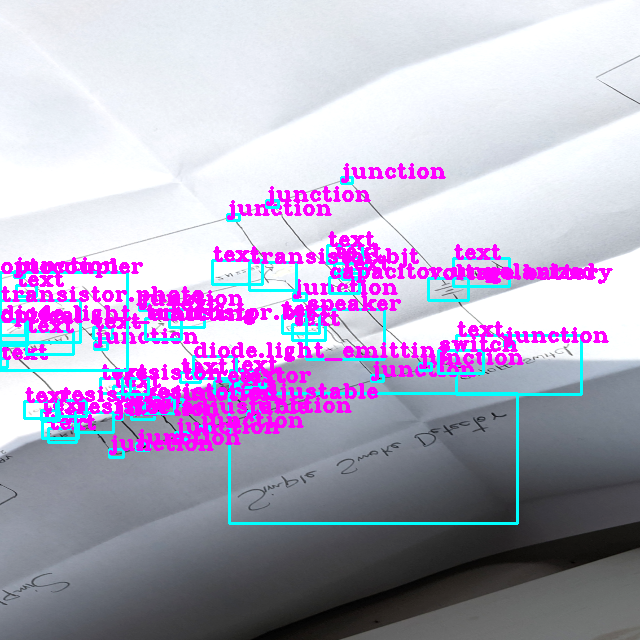

In [17]:
transformed = transform(image=image, bboxes=boxes, classes=class_ids)
print(transformed['classes'], transformed['bboxes'])
put_box(transformed['image'], transformed['classes'], transformed['bboxes'])

# Обрабатываем все снимки

In [18]:
img_dir = './datasets/images/train/'
img_paths = [os.path.join(img_dir, img_name)
             for img_name in os.listdir(img_dir)
             if os.path.isfile(os.path.join(img_dir, img_name))]

In [19]:
def save_labels(save_path, class_ids, boxes):
    with open(save_path, "a") as file:
        for class_id, box in zip(class_ids, boxes):
            box = ' '.join([str(point) for point in box])
            label = f'{class_id} {box}\n'
            file.write(label)

In [20]:
max_augment_count = 5 # С одного изображения делаем ещё 5
for img_path in tqdm(img_paths):
    try:
        for augment_count in range(max_augment_count):
            image, class_ids, boxes = loader(img_path)
            transformed = transform(image=image, bboxes=boxes, classes=class_ids)

            new_img_path, extension = os.path.splitext(img_path)
            new_img_path += f'_aug{augment_count}'

            label_path = new_img_path.replace('images', 'labels')
            label_path += '.txt'

            new_img_path += extension
        
            img = Image.fromarray(transformed['image'])
            if img.mode in {"RGBA", "P"} and extension=='.jpg': 
                img = img.convert("RGB")
            img.save(new_img_path)
            save_labels(label_path, transformed['classes'], transformed['bboxes'])
    except ValueError:
        continue

100%|█████████▉| 1325/1326 [1:28:02<00:03,  3.99s/it] 


UnidentifiedImageError: cannot identify image file './dataset/image/train/desktop.ini'

# Удаление аугоментированных изображений
если нужно будет

In [10]:
aug_img_dir = './datasets/images/train/'
aug_img_paths = [os.path.join(aug_img_dir, img_name)
             for img_name in os.listdir(aug_img_dir)
             if 'aug' in img_name]
print(aug_img_paths[:5])

['./dataset/image/train/C100_D1_P1_aug0.jpg', './dataset/image/train/C100_D1_P1_aug1.jpg', './dataset/image/train/C100_D1_P1_aug2.jpg', './dataset/image/train/C100_D1_P1_aug3.jpg', './dataset/image/train/C100_D1_P1_aug4.jpg']


In [11]:
for img_path in tqdm(aug_img_paths):
    os.remove(img_path)
    label_path =  img_path.replace('images', 'labels').replace(img_path.split('.')[-1], 'txt')
    os.remove(label_path)

100%|██████████| 883/883 [00:00<00:00, 3053.94it/s]
